## Import the needed libraries and dataset

In [4]:
import pandas as pd
import numpy as np

from utils.preprocess import *
from utils.GRU import GRU

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Device:  cuda


In [5]:
file_loc = "data/"

In [6]:
train_data = pd.read_csv(file_loc+"train.csv")
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test_data = pd.read_csv(file_loc+"/test.csv")
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## Data Preprocessing

In [8]:
# dealing with class imbalance
bal_data = balance_class(train_data.copy())

Before Undersampling
--------------------
Train data: (159571, 8)
Toxic data: (16225, 8)
Clean data: (143346, 8)

After Undersampling
-------------------
Balance data: (33225, 8)
Balance toxic data: (16225, 8)
Balance clean data: (17000, 8)


In [9]:
# remove symbols, numbers, non-characters, new line, links, stopwords, and html tags
clean_data = clean(bal_data.copy())

-------------
Cleaning data
-------------
Data cleaned!


In [10]:
text, label = generate_random(clean_data, 'comment_text', 3)
print(f"Original sample comment:\n------------------------\n{text}")
print()
text, label = generate_random(clean_data, 'clean', 3)
print(f"Clean sample comment:\n---------------------\n{text}")

Original sample comment:
------------------------
Yup! Of course I'm blocked! Because you bot assholes can't take the fact that you have no lives. You spend every minute of your life editing WP, and for what?! Organization? More like ORDER.

Clean sample comment:
---------------------
yup of course i'm blocked because bot assholes can't take fact lives you spend every minute life editing wp organization more like order


In [11]:
# remove contractions in text
clean_data = decontract(clean_data)

------------------
Decontracting text
------------------
Texts decontracted!


In [12]:
text, label = generate_random(clean_data, 'clean', 3)
print(f"Clean sample comment:\n---------------------\n{text}")
print()
text, label = generate_random(clean_data, 'decontracted', 3)
print(f"Decontracted sample comment:\n----------------------------\n{text}")

Clean sample comment:
---------------------
yup of course i'm blocked because bot assholes can't take fact lives you spend every minute life editing wp organization more like order

Decontracted sample comment:
----------------------------
yup of course i am blocked because bot assholes cannot take fact lives you spend every minute life editing wp organization more like order


In [13]:
# lemmatize words in text
clean_data = lemmatize(clean_data)

----------------
Lemmatizing text
----------------
Text lemmatized!


In [14]:
text, label = generate_random(clean_data, 'decontracted', 3)
print(f"Decontracted sample comment:\n----------------------------\n{text}")
print()
text, label = generate_random(clean_data, 'lemmatized', 3)
print(f"Lemmatized sample comment:\n--------------------------\n{text}")

Decontracted sample comment:
----------------------------
yup of course i am blocked because bot assholes cannot take fact lives you spend every minute life editing wp organization more like order

Lemmatized sample comment:
--------------------------
 yup of course i be block because bot asshole cannot take fact life you spend every minute life edit wp organization more like order


In [15]:
# split the train data into 80% train and 20% validation
X_train, X_val, y_train, y_val = split_data(clean_data)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

------------------
Splitting the data
------------------
Splitting done!


((26580,), (6645,), (26580, 6), (6645, 6))

In [16]:
# create an instance of the GRU class
gru = GRU()

In [17]:
# tokenize the data
X_test = test_data['comment_text'].to_numpy().reshape(-1,)
X = clean_data["lemmatized"].to_numpy().reshape(-1,)

train_pad, val_pad, test_pad = gru.tokenize(X, X_train, X_test, X_val)
train_pad.shape, test_pad.shape, val_pad.shape

((26580, 200), (153164, 200), (6645, 200))

## Toxic comment classification using GRU

In [18]:
model = gru.build_model()

Building the GRU model...
-------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           100000    
                                                                 
 gru (GRU)                   (None, 64)                22272     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 140,454
Trainable params: 140,454
Non-trainable params: 0
_________________________________________________________________
Done!


In [19]:
model = gru.compile_model(model)

Compiling the GRU model...
--------------------------
Model compiled!


In [20]:
history = gru.train_model(model, train_pad, y_train, val_pad, y_val)

Training the model
------------------
Epoch 1/10
52/52 [==============================] - 18s 166ms/step - loss: 0.4561 - accuracy: 0.9296 - precision: 0.1916 - recall: 0.0140 - auc: 0.6851 - val_loss: 0.3629 - val_accuracy: 0.9710 - val_precision: 1.0000 - val_recall: 4.2918e-04 - val_auc: 0.8397
Epoch 2/10
52/52 [==============================] - 5s 106ms/step - loss: 0.3359 - accuracy: 0.9710 - precision: 0.9024 - recall: 0.1033 - auc: 0.8633 - val_loss: 0.3202 - val_accuracy: 0.9695 - val_precision: 0.7554 - val_recall: 0.5514 - val_auc: 0.9073
Epoch 3/10
52/52 [==============================] - 5s 104ms/step - loss: 0.2650 - accuracy: 0.9720 - precision: 0.8072 - recall: 0.5109 - auc: 0.9168 - val_loss: 0.2322 - val_accuracy: 0.9710 - val_precision: 0.8578 - val_recall: 0.5515 - val_auc: 0.9355
Epoch 4/10
52/52 [==============================] - 4s 73ms/step - loss: 0.2283 - accuracy: 0.9722 - precision: 0.7975 - recall: 0.6387 - auc: 0.9353 - val_loss: 0.2302 - val_accuracy: 0.97

In [21]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.456139,0.929571,0.191614,0.013982,0.685086,0.362908,0.970956,1.000000,0.000429,0.839669
1,0.335949,0.970993,0.902424,0.103316,0.863254,0.320160,0.969451,0.755390,0.551359,0.907324
2,0.264978,0.972047,0.807160,0.510922,0.916809,0.232172,0.970956,0.857810,0.551502,0.935517
3,0.228292,0.972235,0.797548,0.638679,0.935273,0.230220,0.970956,0.724095,0.755794,0.940845
4,0.217016,0.972235,0.799738,0.672015,0.941714,0.209430,0.970805,0.847448,0.641345,0.946617


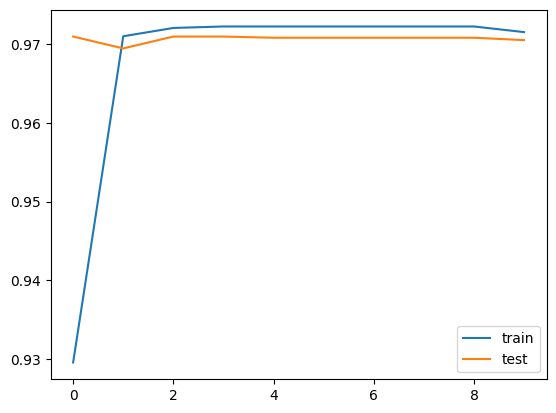

In [22]:
gru.plot_accuracy(history)

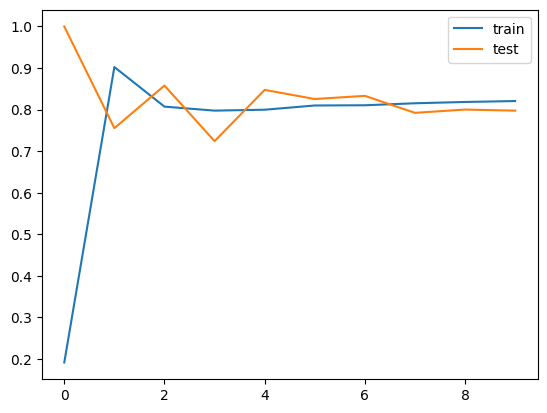

In [23]:
gru.plot_precision(history)

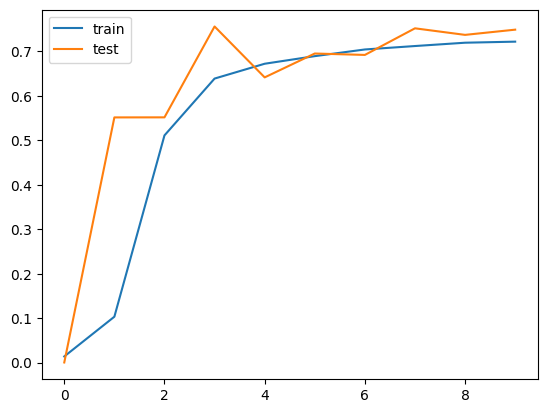

In [24]:
gru.plot_recall(history)

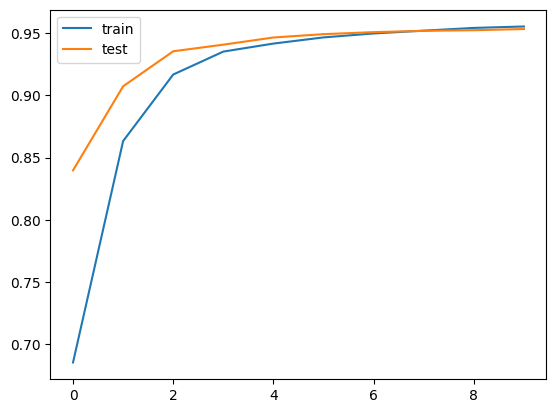

In [25]:
gru.plot_auc(history)

In [26]:
gru.get_accuracy(model, val_pad, y_val, train_pad, y_train)

Results:
--------
Training accuracy: 97.21%

Training loss: 18.86%

Training precision: 80.85%

Training recall: 75.50%

Training auc: 95.89%

---------------
Validation accuracy: 97.05%

Validation loss: 19.78%

Validation precision: 79.75%

Validation recall: 74.86%

Validation auc: 95.34%



In [27]:
gru.save_model(model)

Model saved!


In [28]:
model = gru.load_model()

Model loaded!


In [29]:
col_id = test_data['id']
com_text = test_data['comment_text']
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

pred_result = gru.make_predictions(model, test_pad, col_id, com_text, labels)

4787/4787 [==============================] - 19s 4ms/step


In [30]:
pred_result.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.968435,0.232830,0.879222,0.066497,0.744941,0.154348
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.922501,0.022020,0.407774,0.016168,0.427442,0.052105
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.641388,0.028106,0.214399,0.044589,0.272919,0.077749
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.566836,0.001169,0.060975,0.003776,0.095969,0.008719
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.535313,0.005605,0.106657,0.013498,0.145763,0.026106


In [31]:
text, label = generate_random(pred_result, 'comment_text', 50)
print(f"Sample comment:\n----------------\n{text}")
print()
print(f"Predicted labels:\n--------------------\n{label}")

Sample comment:
----------------
== Wikipedia:Articles_for_deletion/Vedic_mathematics_(book) == 

 Please participate in the debate.

Predicted labels:
--------------------
          toxic  severe_toxic   obscene    threat    insult  identity_hate
14000  0.045321      0.000161  0.010482  0.001354  0.010452       0.002214


In [32]:
text, label = generate_random(pred_result, 'comment_text', 3)
print(f"Sample comment:\n----------------\n{text}")
print()
print(f"Predicted labels:\n--------------------\n{label}")

Sample comment:
----------------
this is a load of BULLSHIT

Predicted labels:
--------------------
         toxic  severe_toxic   obscene    threat   insult  identity_hate
5994  0.953297      0.055487  0.672289  0.020938  0.58251       0.073725
